# IDXExchange real-estate predictive modeling project

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor

All imports are above 

# Step 1: Data Cleaning

In [3]:
file_paths = [
    "CRMLSSold202412.csv",
    "CRMLSSold202501_filled.csv",
    "CRMLSSold202502.csv",
    "CRMLSSold202503.csv",
    "CRMLSSold202504.csv",
    "CRMLSSold202505.csv"
    
]

dfs = [pd.read_csv(path) for path in file_paths]

combined_df = pd.concat(dfs, axis=0, ignore_index=True)

combined_df = combined_df.loc[:, combined_df.columns[:100]]

combined_df.to_csv("combined_output.csv", index=False)

print(" Combined CSV saved as 'combined_output.csv'")

 Combined CSV saved as 'combined_output.csv'


We started by comibining all 6 datasets, into one big megadataset, the code for that is shown above

In [4]:
df = pd.read_csv("combined_output.csv")
df

C:\Users\sunsu\AppData\Local\Temp\ipykernel_27856\1033202321.py:1: DtypeWarning: Columns (78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_output.csv")


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,latfilled,lonfilled
0,Glendale,Glendale,NaN,NaN,NaN,NaN,NaN,3350000.0,552665323,Listings@LockerRealty.com,...,NaN,False,0.0,NaN,91331,NaN,88445.0,NaN,NaN,NaN
1,InlandValleys,InlandValleys,NaN,True,NaN,NaN,NaN,125000.0,551977092,Patriciapandeyrealtor@gmail.com,...,NaN,False,NaN,NaN,92530,0.0,9148.0,NaN,NaN,NaN
2,PacificWest,PacificWest,NaN,True,NaN,NaN,NaN,300000.0,551927931,joshuacho1004@gmail.com,...,NaN,False,NaN,NaN,92356,0.0,6969600.0,NaN,NaN,NaN
3,Mlslistings,Mlslistings,"Carpet,Laminate,Tile",False,NaN,NaN,NaN,800000.0,544420694,assistant@danmoskowitz.com,...,NaN,False,0.0,Other,95122,NaN,6418.0,NaN,NaN,NaN
4,LakeCounty,LakeCounty,NaN,True,NaN,NaN,NaN,21500.0,516603298,jan@zapcom.net,...,NaN,False,NaN,NaN,95464,0.0,4559.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125537,HighDesert,HighDesert,NaN,True,NaN,NaN,NaN,2990000.0,1014021520,kim.hdrealtysource@hotmail.com,...,NaN,False,NaN,NaN,92345,NaN,6969600.0,NaN,NaN,NaN
125538,SanDiego,SanDiego,"Carpet,Laminate,Tile",True,NaN,NaN,False,3295.0,1013198225,calrealestatedoctor@gmail.com,...,NaN,NaN,2.0,NaN,92078,0.0,NaN,NaN,NaN,NaN
125539,NorthSanDiegoCounty,NorthSanDiegoCounty,Wood,True,NaN,NaN,False,5000.0,1008327642,MikeJonesSanDiegoRealtor@Gmail.com,...,NaN,NaN,1.0,Encinitas Union,92024,NaN,1.0,NaN,NaN,NaN
125540,Oakland,Oakland,NaN,NaN,NaN,NaN,NaN,700.0,1002448236,mike@hugheyhomes.com,...,NaN,NaN,NaN,NaN,94803,0.0,0.0,NaN,NaN,NaN


Above is the dataset before cleaning has occured

In [5]:
with pd.option_context('display.max_rows', None):
    print(df.isna().sum())
df.isna().sum() 

BuyerAgentAOR                       45
ListAgentAOR                        45
Flooring                         52107
ViewYN                           12323
WaterfrontYN                    125454
BasementYN                      123491
PoolPrivateYN                    15351
OriginalListPrice                  389
ListingKey                           0
ListAgentEmail                     454
CloseDate                            0
ClosePrice                           3
ListAgentFirstName                 667
ListAgentLastName                   17
Latitude                            20
Longitude                           16
UnparsedAddress                    206
PropertyType                         0
LivingArea                        9191
ListPrice                          208
DaysOnMarket                         0
ListOfficeName                       0
BuyerOfficeName                   1478
CoListOfficeName                 99492
ListAgentFullName                   14
CoListAgentFirstName     

BuyerAgentAOR                       45
ListAgentAOR                        45
Flooring                         52107
ViewYN                           12323
WaterfrontYN                    125454
                                 ...  
AssociationFee                   38798
LotSizeSquareFeet                11102
MiddleOrJuniorSchoolDistrict    125542
latfilled                       106804
lonfilled                       106804
Length: 80, dtype: int64

Above shows us the number of NA values per columns

In [6]:
fdf = df[[
    "ViewYN",
    "PoolPrivateYN",
    "LivingArea",
    "CountyOrParish",
    "PropertySubType",
    "PropertyType",
    "LotSizeSquareFeet",
    "YearBuilt",
    "BathroomsTotalInteger",
    "BedroomsTotal",
    "GarageSpaces",
    "ClosePrice",
    "NewConstructionYN",
    "Levels",
    "ParkingTotal",
    "FireplaceYN",
    "City",
    "Latitude",
    "Longitude",
    "StateOrProvince",
    "PostalCode"
]]
fdf

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,NaN,NaN,NaN,Los Angeles,NaN,Land,88445.0,NaN,0.0,NaN,...,2100000.0,False,NaN,0.0,NaN,Pacoima,34.271680,-118.403023,CA,91331
1,True,NaN,NaN,Riverside,NaN,Land,9148.0,NaN,NaN,NaN,...,125000.0,False,NaN,NaN,NaN,Lake Elsinore,33.668691,-117.334438,CA,92530
2,True,NaN,NaN,San Bernardino,NaN,Land,6969600.0,NaN,NaN,NaN,...,135000.0,False,NaN,NaN,NaN,Lucerne Valley,34.499080,-116.857925,CA,92356
3,False,NaN,1151.0,Santa Clara,SingleFamilyResidence,Residential,6418.0,1979.0,6.0,8.0,...,1120000.0,False,NaN,0.0,True,San Jose,37.330858,-121.849610,CA,95122
4,True,NaN,NaN,Lake,NaN,Land,4559.0,NaN,NaN,NaN,...,4000.0,False,NaN,NaN,NaN,Nice,39.125024,-122.860206,CA,95464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125537,True,NaN,NaN,San Bernardino,NaN,Land,6969600.0,NaN,NaN,NaN,...,4000000.0,False,NaN,NaN,NaN,Oak Hills,34.353014,-117.426088,CA,92345
125538,True,False,1229.0,San Diego,SingleFamilyResidence,ResidentialLease,NaN,2020.0,3.0,2.0,...,3395.0,NaN,Two,4.0,True,San Marcos,33.117347,-117.165102,CA,92078
125539,True,False,956.0,San Diego,Condominium,ResidentialLease,1.0,2010.0,1.0,1.0,...,5500.0,NaN,One,1.0,False,Encinitas,33.043863,-117.293071,CA,92024
125540,NaN,NaN,NaN,Contra Costa,NaN,CommercialSale,0.0,NaN,0.0,NaN,...,400.0,NaN,NaN,0.0,NaN,El Sobrante,37.983172,-122.302091,CA,94803


Above is the first part to cleaning the dataset. We initially started off with 80 rows but we trimmed it down to 16, this was done by manually inspecting rows, and removing rows that either had too many NA values, or seemed to have no impact on "ClosePrice" whatsoever. For example "Flooring" in theory is a vraible that could potentially have an impact on the "ClosePrice", however it has 50,000+ NA values, which is almost 40% of the dataset gone. Another example is the variable "ListAgentAOR". List agent first of all does not seem to be an indicator of a houses sale price, secondly there are simple too many list agents for it to have a positive affect on the model

In [7]:
fdf.isna().sum() 

ViewYN                   12323
PoolPrivateYN            15351
LivingArea                9191
CountyOrParish               0
PropertySubType           9956
PropertyType                 0
LotSizeSquareFeet        11102
YearBuilt                 5629
BathroomsTotalInteger     5990
BedroomsTotal             8655
GarageSpaces             16850
ClosePrice                   3
NewConstructionYN        14939
Levels                   16824
ParkingTotal              4031
FireplaceYN              11241
City                       103
Latitude                    20
Longitude                   16
StateOrProvince              0
PostalCode                  29
dtype: int64

Above is the NA values after reducing columsn from 80 to 20

In [8]:
fdf = fdf.dropna().reset_index(drop=True)
fdf.shape[0]

72474

In [9]:
fdf

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,True,False,1434.0,Los Angeles,SingleFamilyResidence,Residential,6473.0,1940.0,1.0,3.0,...,890000.0,False,One,1.0,True,Burbank,34.180411,-118.342020,CA,91505
1,False,False,2872.0,San Diego,SingleFamilyResidence,Residential,5219.0,2001.0,3.0,5.0,...,1138000.0,False,Two,6.0,True,San Diego,32.574359,-117.023836,CA,92154
2,True,False,2824.0,Riverside,SingleFamilyResidence,Residential,7000.0,2024.0,3.0,5.0,...,681877.0,True,Two,2.0,False,Menifee,33.725080,-117.222302,CA,92586
3,True,False,2500.0,Los Angeles,SingleFamilyResidence,Residential,8336.0,1971.0,3.0,5.0,...,900000.0,False,Two,2.0,True,Los Angeles,34.203479,-118.643567,CA,91307
4,False,False,2363.0,Los Angeles,SingleFamilyResidence,Residential,11705.0,1995.0,3.0,5.0,...,862000.0,False,Two,2.0,True,Saugus,34.460368,-118.490755,CA,91390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72469,False,False,1014.0,Los Angeles,SingleFamilyResidence,Residential,4225.0,1926.0,1.0,2.0,...,510000.0,False,One,1.0,False,Los Angeles,33.943555,-118.285762,CA,90044
72470,False,False,500.0,Orange,Duplex,ResidentialLease,10500.0,1961.0,1.0,0.0,...,2350.0,False,One,0.0,False,San Clemente,33.418396,-117.612445,CA,92672
72471,True,False,1142.0,Riverside,Condominium,Residential,1307.0,1977.0,2.0,2.0,...,250000.0,False,One,1.0,False,Palm Springs,33.792292,-116.545330,CA,92264
72472,True,False,1550.0,Orange,SingleFamilyResidence,ResidentialLease,4995.0,1953.0,2.0,3.0,...,4500.0,False,One,2.0,True,San Clemente,33.417391,-117.607257,CA,92672


Above is the resulting rows after dropping NA values for the 20 columns, we are left with little over half the rows we started with

In [10]:
fdf.dtypes

ViewYN                    object
PoolPrivateYN             object
LivingArea               float64
CountyOrParish            object
PropertySubType           object
PropertyType              object
LotSizeSquareFeet        float64
YearBuilt                float64
BathroomsTotalInteger    float64
BedroomsTotal            float64
GarageSpaces             float64
ClosePrice               float64
NewConstructionYN         object
Levels                    object
ParkingTotal             float64
FireplaceYN               object
City                      object
Latitude                 float64
Longitude                float64
StateOrProvince           object
PostalCode                object
dtype: object

In [11]:
fdf["Latitude"] = fdf["Latitude"].round(2)
fdf["Longitude"] = fdf["Longitude"].round(2)

In [12]:
fdf['PostalCode'] = fdf['PostalCode'].str.split('-').str[0]
#fdf = fdf.dropna().reset_index(drop=True)
fdf['PostalCode'] = fdf['PostalCode'].astype(int)

fdf['PostalCode'] = (fdf['PostalCode'] // 100) * 100

Becuase each house has their own unique longitude and latitude we grouped them into buckets by rounds each longitude and latitude to the nearest hundreths

In [13]:
#fdf["Postal_Code_Rounded"] = fdf[fdf["PostalCode"].astype(float)]

ignore above 

In [14]:
view_counts = fdf["ViewYN"].value_counts()
view_counts

ViewYN
True     46296
False    26178
Name: count, dtype: int64

In [15]:
pool_counts = fdf["PoolPrivateYN"].value_counts()
pool_counts

PoolPrivateYN
False    62240
True     10234
Name: count, dtype: int64

In [16]:
counts = fdf["CountyOrParish"].value_counts()
counts

x = counts[counts > 1]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['CountyOrParish'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["CountyOrParish"].value_counts()
counts

CountyOrParish
Los Angeles        24120
Orange             13744
Riverside          12628
San Bernardino      9268
San Diego           5137
San Luis Obispo     1182
Ventura             1066
Butte                770
Contra Costa         756
Kern                 715
Alameda              611
Merced               462
Lake                 388
Santa Barbara        323
Fresno               269
Madera               247
Tehama                85
Glenn                 75
Mariposa              63
Stanislaus            63
Tulare                59
Santa Clara           47
Imperial              46
Kings                 37
Solano                34
Yuba                  31
San Francisco         29
San Joaquin           25
Sacramento            21
Sutter                21
San Mateo             19
Mendocino             15
Monterey              13
Shasta                11
Placer                 9
Sonoma                 8
Mono                   7
El Dorado              7
Napa                   7
Plumas    

In [17]:
#PropertySubType	PropertyType City		NewConstructionYN	Levels
counts = fdf["PropertySubType"].value_counts()
counts


x = counts[counts >= 11000]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['PropertySubType'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["PropertySubType"].value_counts()
counts

PropertySubType
SingleFamilyResidence    52610
Name: count, dtype: int64

In [18]:
counts = fdf["PropertyType"].value_counts()
counts


x = counts[counts >= 19000]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['PropertyType'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["PropertyType"].value_counts()
counts

PropertyType
Residential    42771
Name: count, dtype: int64

In [19]:
counts = fdf["NewConstructionYN"].value_counts()
counts

NewConstructionYN
False    40658
True      2113
Name: count, dtype: int64

In [20]:
counts = fdf["Levels"].value_counts()
counts

x = counts[counts >= 262]
top_pub_counts = x.index
top_pub_counts
fdf = fdf[fdf['Levels'].isin(top_pub_counts)]
fdf.shape[0]

counts = fdf["Levels"].value_counts()
counts

Levels
One            26962
Two            14244
ThreeOrMore      872
MultiSplit       410
Name: count, dtype: int64

In [21]:
fdf.isna().sum() 

ViewYN                   0
PoolPrivateYN            0
LivingArea               0
CountyOrParish           0
PropertySubType          0
PropertyType             0
LotSizeSquareFeet        0
YearBuilt                0
BathroomsTotalInteger    0
BedroomsTotal            0
GarageSpaces             0
ClosePrice               0
NewConstructionYN        0
Levels                   0
ParkingTotal             0
FireplaceYN              0
City                     0
Latitude                 0
Longitude                0
StateOrProvince          0
PostalCode               0
dtype: int64

The code above was used to get rid of rows that may have had only 1 variable type. For example the variable "Levels" initially had a type called "FourOrMore" but only one row had that, when breaking up data into train and testing datasets, this will cause issues so we went ahead and removed all types that where not atleast 256 other rows. This same process was done for all other variables, however the number of rows critieria changed depending on variable

ignore above 

<Axes: xlabel='LivingArea', ylabel='ClosePrice'>

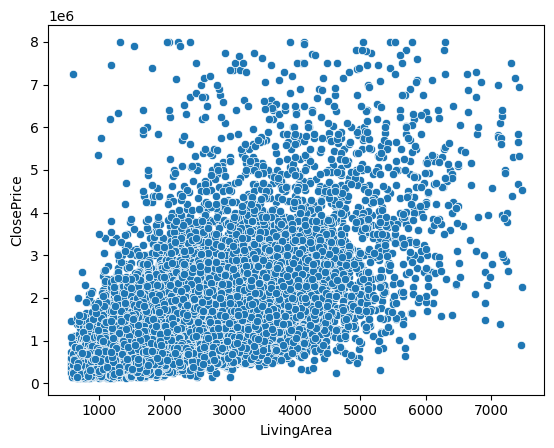

In [22]:
# fdf = fdf[fdf['ClosePrice'] < 8e7]
# fdf = fdf[fdf['LivingArea'] < 16000]

# def clip_extremes(df, column, lower_pct=0.01, upper_pct=0.99):
#     lower_bound = df[column].quantile(lower_pct)
#     upper_bound = df[column].quantile(upper_pct)
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# # Example usage:
# fdf = clip_extremes(fdf, 'ClosePrice')
# fdf = clip_extremes(fdf, 'LivingArea')

def clip_extremes(df, column, lower_pct = 0.0025, upper_pct = 0.9975):
    lower_bound = df[column].quantile(lower_pct)
    upper_bound = df[column].quantile(upper_pct)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

fdf = clip_extremes(fdf,'LivingArea')
fdf = clip_extremes(fdf,'ClosePrice')

sns.scatterplot(x = "LivingArea", y= "ClosePrice", data = fdf)

<Axes: xlabel='LotSizeSquareFeet', ylabel='ClosePrice'>

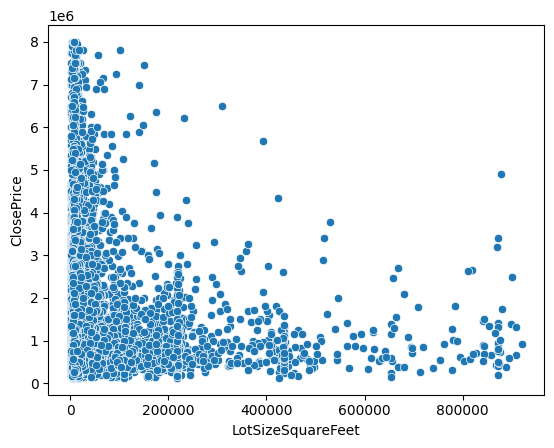

In [23]:
#LotSizeSquareFeet	YearBuilt	BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal

fdf = clip_extremes(fdf,'LotSizeSquareFeet')
sns.scatterplot(x = "LotSizeSquareFeet", y= "ClosePrice", data = fdf)

<Axes: xlabel='YearBuilt', ylabel='ClosePrice'>

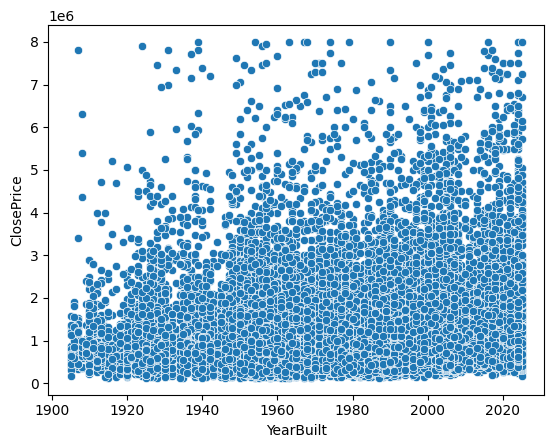

In [24]:
# #		YearBuilt	BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal

fdf = clip_extremes(fdf,'YearBuilt')
sns.scatterplot(x = "YearBuilt", y= "ClosePrice", data = fdf)

<Axes: xlabel='BathroomsTotalInteger', ylabel='ClosePrice'>

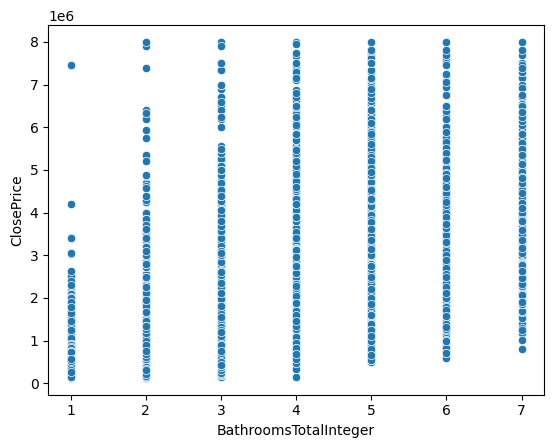

In [25]:
# #		BathroomsTotalInteger BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = clip_extremes(fdf,'BathroomsTotalInteger')
sns.scatterplot(x = "BathroomsTotalInteger", y= "ClosePrice", data = fdf)

<Axes: xlabel='BedroomsTotal', ylabel='ClosePrice'>

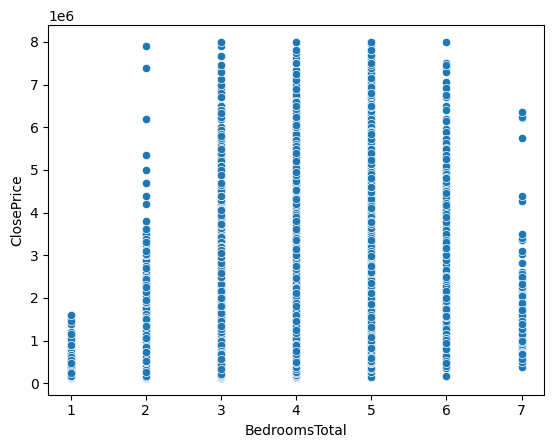

In [26]:
# #	 BedroomsTotal	GarageSpaces	ClosePrice		ParkingTotal
fdf = clip_extremes(fdf,'BedroomsTotal')
sns.scatterplot(x = "BedroomsTotal", y= "ClosePrice", data = fdf)

<Axes: xlabel='GarageSpaces', ylabel='ClosePrice'>

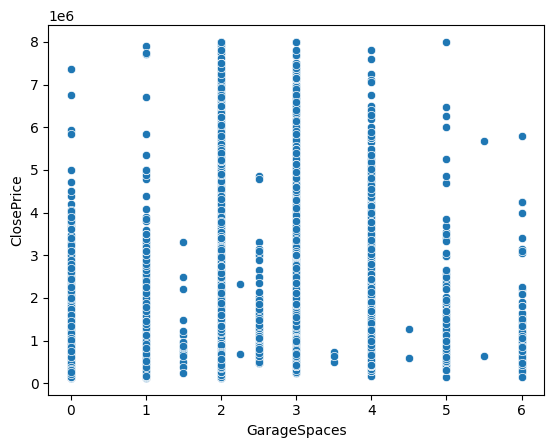

In [27]:
# #			GarageSpaces	ClosePrice		ParkingTotal
fdf = clip_extremes(fdf,'GarageSpaces')
sns.scatterplot(x = "GarageSpaces", y= "ClosePrice", data = fdf)

<Axes: xlabel='ParkingTotal', ylabel='ClosePrice'>

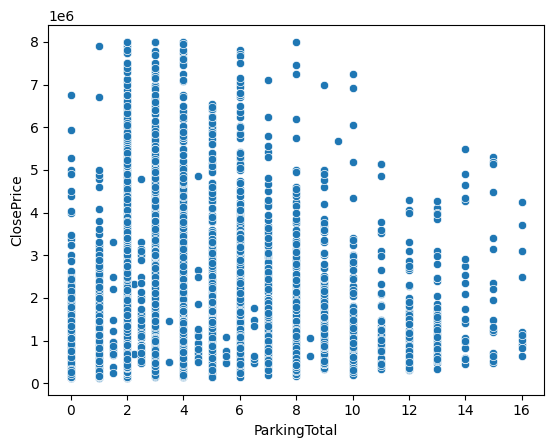

In [28]:
# #			ClosePrice		ParkingTotal
fdf = clip_extremes(fdf,'ParkingTotal')
sns.scatterplot(x = "ParkingTotal", y= "ClosePrice", data = fdf)

<Axes: xlabel='Longitude', ylabel='ClosePrice'>

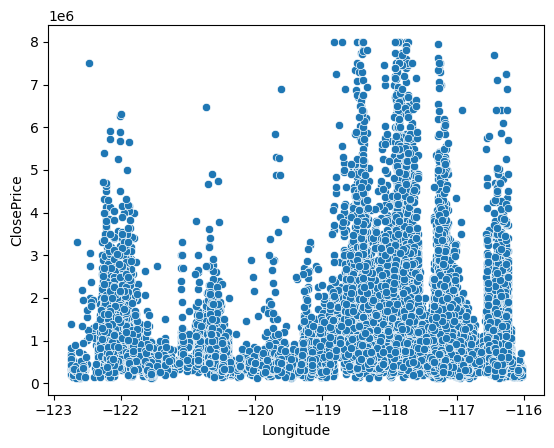

In [29]:
fdf = clip_extremes(fdf,'Longitude')
sns.scatterplot(x = "Longitude", y= "ClosePrice", data = fdf)

<Axes: xlabel='Latitude', ylabel='ClosePrice'>

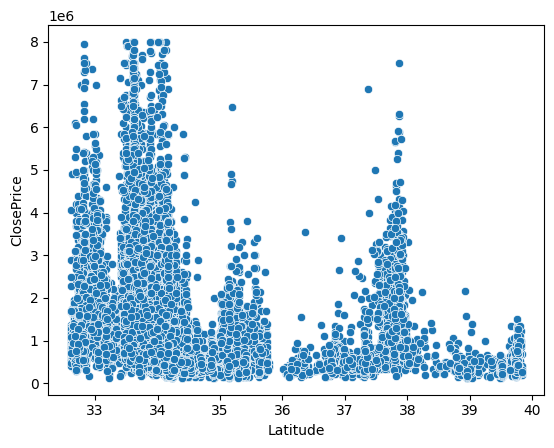

In [30]:
fdf = clip_extremes(fdf,'Latitude')
sns.scatterplot(x = "Latitude", y= "ClosePrice", data = fdf)

In [31]:
df_orig = fdf.copy()

Same thing that was done for the categorical variables, will be done to the numerical variables, variables that seemes to high where removed to preserve the usability of a linear regression model

In [32]:
fdf.shape[0]

41116

In [33]:
fdf_nn = fdf

# Step 2 Pre-Processing Data

Above is the number of rows left after cleaning the data

In [34]:
fdf.corr(numeric_only=True)

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,PostalCode
LivingArea,1.000000,0.108373,0.415815,0.835684,0.660985,0.489710,0.600278,0.312045,-0.048401,0.030523,0.043469
LotSizeSquareFeet,0.108373,1.000000,0.047047,0.064254,0.015593,0.033429,0.011000,0.084370,0.108385,-0.057592,0.102135
YearBuilt,0.415815,0.047047,1.000000,0.432150,0.285980,0.400596,0.017882,0.175993,0.027608,0.139051,0.271342
BathroomsTotalInteger,0.835684,0.064254,0.432150,1.000000,0.628807,0.407003,0.564334,0.262457,-0.073358,0.043386,0.024013
BedroomsTotal,0.660985,0.015593,0.285980,0.628807,1.000000,0.359258,0.326380,0.205075,-0.063726,0.025173,0.019709
GarageSpaces,0.489710,0.033429,0.400596,0.407003,0.359258,1.000000,0.224952,0.467922,-0.067031,0.076120,0.058164
ClosePrice,0.600278,0.011000,0.017882,0.564334,0.326380,0.224952,1.000000,0.193233,-0.152860,-0.054714,-0.137665
ParkingTotal,0.312045,0.084370,0.175993,0.262457,0.205075,0.467922,0.193233,1.000000,-0.138698,0.136959,0.011963
Latitude,-0.048401,0.108385,0.027608,-0.073358,-0.063726,-0.067031,-0.152860,-0.138698,1.000000,-0.848925,0.599981
Longitude,0.030523,-0.057592,0.139051,0.043386,0.025173,0.076120,-0.054714,0.136959,-0.848925,1.000000,-0.428978


As we can see above, there is multicollinearity, so we have to use LASSO, RIDGE or ELASTIC NET to help us with this issue

In [35]:
from sklearn.preprocessing import StandardScaler


Scaler_training = StandardScaler()
scaled_expl_vars_test = Scaler_training.fit_transform(fdf[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']])


fdf[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']] = scaled_expl_vars_test
fdf.head()

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode,BathroomTotalInteger
0,True,False,-0.645482,Los Angeles,SingleFamilyResidence,Residential,-0.203205,-1.444719,1.0,-0.519545,...,False,One,-0.968632,True,Burbank,34.18,-118.34,CA,91500,-1.590309
2,True,False,0.957903,Riverside,SingleFamilyResidence,Residential,-0.191742,1.704809,3.0,1.698345,...,True,Two,-0.400237,False,Menifee,33.73,-117.22,CA,92500,0.426070
3,True,False,0.584165,Los Angeles,SingleFamilyResidence,Residential,-0.162683,-0.282393,3.0,1.698345,...,False,Two,-0.400237,True,Los Angeles,34.20,-118.64,CA,91300,0.426070
4,False,False,0.426133,Los Angeles,SingleFamilyResidence,Residential,-0.089403,0.617472,3.0,1.698345,...,False,Two,-0.400237,True,Saugus,34.46,-118.49,CA,91300,0.426070
5,True,False,3.377977,Placer,SingleFamilyResidence,Residential,-0.068152,0.954921,4.0,2.807289,...,False,Two,0.168157,True,Roseville,38.73,-121.35,CA,95700,1.434260


Z scored all numerical variables 

In [36]:
df_orig

,ViewYN,PoolPrivateYN,LivingArea,CountyOrParish,PropertySubType,PropertyType,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,...,ClosePrice,NewConstructionYN,Levels,ParkingTotal,FireplaceYN,City,Latitude,Longitude,StateOrProvince,PostalCode
0,True,False,1434.0,Los Angeles,SingleFamilyResidence,Residential,6473.0,1940.0,1.0,3.0,...,890000.0,False,One,1.0,True,Burbank,34.18,-118.34,CA,91500
2,True,False,2824.0,Riverside,SingleFamilyResidence,Residential,7000.0,2024.0,3.0,5.0,...,681877.0,True,Two,2.0,False,Menifee,33.73,-117.22,CA,92500
3,True,False,2500.0,Los Angeles,SingleFamilyResidence,Residential,8336.0,1971.0,3.0,5.0,...,900000.0,False,Two,2.0,True,Los Angeles,34.20,-118.64,CA,91300
4,False,False,2363.0,Los Angeles,SingleFamilyResidence,Residential,11705.0,1995.0,3.0,5.0,...,862000.0,False,Two,2.0,True,Saugus,34.46,-118.49,CA,91300
5,True,False,4922.0,Placer,SingleFamilyResidence,Residential,12682.0,2004.0,4.0,6.0,...,1050000.0,False,Two,3.0,True,Roseville,38.73,-121.35,CA,95700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,False,False,1305.0,Riverside,SingleFamilyResidence,Residential,6969.0,1962.0,1.0,2.0,...,265000.0,False,One,0.0,False,Sun City,33.70,-117.20,CA,92500
72467,True,True,1869.0,San Bernardino,SingleFamilyResidence,Residential,217800.0,2023.0,2.0,3.0,...,1350000.0,True,One,2.0,True,Joshua Tree,34.12,-116.32,CA,92200
72468,True,False,1811.0,Madera,SingleFamilyResidence,Residential,13068.0,1987.0,2.0,4.0,...,757000.0,False,Two,0.0,True,Bass Lake,37.32,-119.55,CA,93600
72469,False,False,1014.0,Los Angeles,SingleFamilyResidence,Residential,4225.0,1926.0,1.0,2.0,...,510000.0,False,One,1.0,False,Los Angeles,33.94,-118.29,CA,90000


In [37]:
categorical_df = fdf[['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'NewConstructionYN', 'Levels', 'FireplaceYN','City','StateOrProvince']]
categorical_df
indicator_df = pd.get_dummies(categorical_df, drop_first=True, dtype=int)
indicator_df
fdf = fdf.drop(columns=categorical_df.columns)
fdf = pd.concat([fdf, indicator_df], axis=1)
fdf

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
0,-0.645482,-0.203205,-1.444719,1.0,-0.519545,-1.242302,890000.0,-0.968632,34.18,-118.34,...,0,0,0,0,0,0,0,0,0,0
2,0.957903,-0.191742,1.704809,3.0,1.698345,0.003484,681877.0,-0.400237,33.73,-117.22,...,0,0,0,0,0,0,0,0,0,0
3,0.584165,-0.162683,-0.282393,3.0,1.698345,0.003484,900000.0,-0.400237,34.20,-118.64,...,0,0,0,0,0,0,0,0,0,0
4,0.426133,-0.089403,0.617472,3.0,1.698345,0.003484,862000.0,-0.400237,34.46,-118.49,...,0,0,0,0,0,0,0,0,0,0
5,3.377977,-0.068152,0.954921,4.0,2.807289,1.249271,1050000.0,0.168157,38.73,-121.35,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,-0.794285,-0.192416,-0.619843,1.0,-1.628489,-2.488088,265000.0,-1.537026,33.70,-117.20,...,0,0,0,0,0,0,0,0,0,0
72467,-0.143703,4.393414,1.667314,2.0,-0.519545,0.003484,1350000.0,-0.400237,34.12,-116.32,...,0,0,0,0,0,0,0,0,0,0
72468,-0.210607,-0.059756,0.317517,2.0,0.589400,-2.488088,757000.0,-1.537026,37.32,-119.55,...,0,0,0,0,0,0,0,0,0,0
72469,-1.129958,-0.252102,-1.969640,1.0,-1.628489,-1.242302,510000.0,-0.968632,33.94,-118.29,...,0,0,0,0,0,0,0,0,0,0


We will need to use pd.getDummies for categorical variables, as thats the only way Risge, Lasso, Elastic Net, Random Forest and XGBoost work

In [38]:
categorical_df1 = df_orig[['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'NewConstructionYN', 'Levels', 'FireplaceYN','City','StateOrProvince']]
categorical_df1
indicator_df1 = pd.get_dummies(categorical_df1, drop_first=True, dtype=int)
indicator_df1
df_orig = df_orig.drop(columns=categorical_df1.columns)
df_orig = pd.concat([df_orig, indicator_df1], axis=1)
df_orig

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ClosePrice,ParkingTotal,Latitude,Longitude,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
0,1434.0,6473.0,1940.0,1.0,3.0,1.0,890000.0,1.0,34.18,-118.34,...,0,0,0,0,0,0,0,0,0,0
2,2824.0,7000.0,2024.0,3.0,5.0,2.0,681877.0,2.0,33.73,-117.22,...,0,0,0,0,0,0,0,0,0,0
3,2500.0,8336.0,1971.0,3.0,5.0,2.0,900000.0,2.0,34.20,-118.64,...,0,0,0,0,0,0,0,0,0,0
4,2363.0,11705.0,1995.0,3.0,5.0,2.0,862000.0,2.0,34.46,-118.49,...,0,0,0,0,0,0,0,0,0,0
5,4922.0,12682.0,2004.0,4.0,6.0,3.0,1050000.0,3.0,38.73,-121.35,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72466,1305.0,6969.0,1962.0,1.0,2.0,0.0,265000.0,0.0,33.70,-117.20,...,0,0,0,0,0,0,0,0,0,0
72467,1869.0,217800.0,2023.0,2.0,3.0,2.0,1350000.0,2.0,34.12,-116.32,...,0,0,0,0,0,0,0,0,0,0
72468,1811.0,13068.0,1987.0,2.0,4.0,0.0,757000.0,0.0,37.32,-119.55,...,0,0,0,0,0,0,0,0,0,0
72469,1014.0,4225.0,1926.0,1.0,2.0,1.0,510000.0,1.0,33.94,-118.29,...,0,0,0,0,0,0,0,0,0,0


Pd.getDummies done for this dataset as well

# Step 3 Machine Learning

## Starting Linear Regression Ridge

In [39]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(fdf, test_size = 0.20, random_state = 207)

Splitting data into train test split

In [40]:
feature_train = df_train.drop(['ClosePrice'], axis=1)
feature_train.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
31682,2.103343,0.122693,0.917427,5.0,0.589400,2.495057,0.736551,34.14,-117.53,91700,...,0,0,0,0,0,0,0,0,0,0
46404,0.219654,0.712064,-0.094921,2.0,0.589400,0.003484,-0.400237,34.64,-118.22,93500,...,0,0,0,0,0,0,0,0,0,0
15391,-0.232524,-0.235092,-0.994787,2.0,-0.519545,0.003484,0.736551,33.88,-118.32,90500,...,0,0,0,0,0,0,0,0,0,0
1588,-0.440156,-0.220824,0.992416,2.0,-0.519545,0.003484,-0.400237,39.12,-121.65,95900,...,0,0,0,0,0,0,0,1,0,0
36581,-1.000765,-0.228958,-1.032281,2.0,-0.519545,0.003484,1.873340,33.91,-118.37,90200,...,0,0,0,0,0,0,0,0,0,0


In [41]:
feature_test = df_test.drop(['ClosePrice'], axis=1)
feature_test.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
49224,1.683464,-0.201878,1.517337,3.0,0.589400,1.249271,0.168157,33.62,-117.13,92500,...,0,0,0,0,0,0,0,0,0,0
62816,-0.562429,-0.154591,-0.169910,2.0,-0.519545,0.003484,1.304946,33.98,-117.86,91700,...,0,0,0,0,0,0,0,0,0,0
52956,0.475734,-0.147478,1.742303,3.0,0.589400,0.003484,0.736551,35.11,-118.45,93500,...,0,0,0,0,0,0,0,0,0,0
36594,-0.638561,2.117084,0.017562,2.0,-0.519545,-2.488088,-1.537026,34.69,-117.76,93500,...,0,0,0,0,0,0,0,0,0,0
59771,0.122759,-0.243336,0.055056,3.0,0.589400,0.003484,0.736551,37.64,-122.45,94000,...,0,0,0,0,0,0,0,0,0,0


In [42]:
target_train = df_train["ClosePrice"]
target_train


31682    1800000.0
46404     645000.0
15391     989000.0
1588      426500.0
36581    1103000.0
           ...    
13977    1050000.0
70605     905000.0
69384     504900.0
21930     950000.0
36491     559000.0
Name: ClosePrice, Length: 32892, dtype: float64

In [43]:
target_test = df_test["ClosePrice"]
target_test

49224     745000.0
62816     870000.0
52956     599990.0
36594     208000.0
59771    1908000.0
           ...    
37253     676000.0
67517    1800000.0
52813    1100000.0
59563     425000.0
40329     680000.0
Name: ClosePrice, Length: 8224, dtype: float64

Split the data into training features matrix, traing target array, and test features matrix and test target array

In [44]:
from sklearn.linear_model import LinearRegression

lin_reg_mod = LinearRegression()

Here I am checking if the data is fit for a linear regression model, as we can see the residual plot clearly does not fit, as a result, we may need to use other models outside of linear regression

In [45]:
# import numpy as np
# from sklearn.linear_model import Ridge, Lasso
# data = []
# for i in np.arange(0,0.9,0.005):
#     lin_reg_mod = Ridge(alpha=i, max_iter=1000)
#     lin_reg_mod.fit(feature_train, target_train)
#     x = lin_reg_mod.score(feature_test, target_test)
#     data.append([i, x])
# df_rsqrR = pd.DataFrame(data, columns=['lambda', 'test_r2'])
# df_rsqrR


Started off by hyperparameter tuning lambda values for ridge

In [46]:
# df_rsqrR.nlargest(1,"test_r2")

Above is the highest r2 for ridge with the best lambda value, at 0.71

In [47]:
# plt.plot(df_rsqrR['lambda'].values, df_rsqrR['test_r2'].values)

Above is a visual representation of the performance of different lambda values

## Starting Linear Reegression Lasso

In [48]:
# import numpy as np
# from sklearn.linear_model import Ridge, Lasso
# data = []
# for i in np.arange(0,0.9,0.005):
#     lin_reg_mod = Lasso(alpha=i, max_iter=1000)
#     lin_reg_mod.fit(feature_train, target_train)
#     x = lin_reg_mod.score(feature_test, target_test)
#     data.append([i, x])
# df_rsqrL = pd.DataFrame(data, columns=['lambda', 'test_r2'])
# df_rsqrL


Lambda of 0 gets us the highest test r2 of 0.71

Same thing that was done for ridge, is now being done with Lasso

In [49]:
# df_rsqrL.nlargest(1,'test_r2')

In [50]:
# plt.plot(df_rsqrL['lambda'].values, df_rsqrL['test_r2'].values)

Above is a visual representation of the ridge hyperparameter tuning performance

## Starting Linear Reegression ELastic Net

In [51]:
# data = []
# for alpha_val in np.arange(0.001, 0.9, 0.005):
#     model = ElasticNet(alpha=alpha_val, l1_ratio=0.2, max_iter=10000)
#     model.fit(feature_train, target_train)
#     test_r2 = model.score(feature_test, target_test)
#     data.append([alpha_val, test_r2])

# # Convert to DataFrame
# df_rsqrE = pd.DataFrame(data, columns=['alpha', 'test_r2'])
# df_rsqrE

Same thing as Ridge and Lasso now being doen for elastic net

In [52]:
# df_rsqrE.nlargest(1,"test_r2")

Highest lambda of 0.001 gave us the highest r2 at 0.68

In [53]:
# plt.plot(df_rsqrE['alpha'].values, df_rsqrE['test_r2'].values)

Above is a visual representation of the elastic net performance

### Starting K fold cross validation on Linear Reegression Ridge

In [54]:
# from sklearn.model_selection import KFold
# crossval = KFold(n_splits=5, shuffle=True, random_state=437)
# crossval

# data = []
# for i in np.arange(0,0.51,0.01):
#     ridge1 = Ridge(alpha=i, max_iter=1000)
#     test_fold_r2 = cross_val_score(ridge1, feature_train, target_train, cv=crossval, scoring="r2")
#     data.append([i, test_fold_r2, test_fold_r2.mean()])
# df_ptune = pd.DataFrame(data, columns=['lambda', 'rsqrs', 'mean_rsqr'])
# df_ptune


Since Ridge was the best perorming model, I decided to impliment K-fold cross validation on it, just to make sure the test r2 is accurate, which it is

In [55]:
# df_ptune.nlargest(1,'mean_rsqr')

### Starting Random Forest Regression

In [56]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
df_train_rf, df_test_rf = train_test_split(df_orig, test_size = 0.20, random_state = 207)


simply importing the model

In [57]:
feature_train_rf = df_train_rf.drop(['ClosePrice'], axis=1)
feature_train_rf.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
31682,3817.0,21456.0,2003.0,5.0,4.0,4.0,4.0,34.14,-117.53,91700,...,0,0,0,0,0,0,0,0,0,0
46404,2184.0,48552.0,1976.0,2.0,4.0,2.0,2.0,34.64,-118.22,93500,...,0,0,0,0,0,0,0,0,0,0
15391,1792.0,5007.0,1952.0,2.0,3.0,2.0,4.0,33.88,-118.32,90500,...,0,0,0,0,0,0,0,0,0,0
1588,1612.0,5663.0,2005.0,2.0,3.0,2.0,2.0,39.12,-121.65,95900,...,0,0,0,0,0,0,0,1,0,0
36581,1126.0,5289.0,1951.0,2.0,3.0,2.0,6.0,33.91,-118.37,90200,...,0,0,0,0,0,0,0,0,0,0


In [58]:
feature_test_rf = df_test_rf.drop(['ClosePrice'], axis=1)
feature_test_rf.head()

,LivingArea,LotSizeSquareFeet,YearBuilt,BathroomsTotalInteger,BedroomsTotal,GarageSpaces,ParkingTotal,Latitude,Longitude,PostalCode,...,City_Woodland,City_Woodland Hills,City_Woodside,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yosemite,City_Yuba City,City_Yucaipa,City_Yucca Valley
49224,3453.0,6534.0,2019.0,3.0,4.0,3.0,3.0,33.62,-117.13,92500,...,0,0,0,0,0,0,0,0,0,0
62816,1506.0,8708.0,1974.0,2.0,3.0,2.0,5.0,33.98,-117.86,91700,...,0,0,0,0,0,0,0,0,0,0
52956,2406.0,9035.0,2025.0,3.0,4.0,2.0,4.0,35.11,-118.45,93500,...,0,0,0,0,0,0,0,0,0,0
36594,1440.0,113147.0,1979.0,2.0,3.0,0.0,0.0,34.69,-117.76,93500,...,0,0,0,0,0,0,0,0,0,0
59771,2100.0,4628.0,1980.0,3.0,4.0,2.0,4.0,37.64,-122.45,94000,...,0,0,0,0,0,0,0,0,0,0


In [59]:
target_train_rf = np.log1p(df_train_rf["ClosePrice"])
target_train_rf


31682    14.403298
46404    13.377007
15391    13.804451
1588     12.963370
36581    13.913545
           ...    
13977    13.864302
70605    13.715691
69384    13.132118
21930    13.764218
36491    13.233907
Name: ClosePrice, Length: 32892, dtype: float64

In [60]:
target_test_rf = np.log1p(df_test_rf["ClosePrice"])
target_test_rf

49224    13.521141
62816    13.676250
52956    13.304670
36594    12.245298
59771    14.461567
           ...    
37253    13.423950
67517    14.403298
52813    13.910822
59563    12.959847
40329    13.429850
Name: ClosePrice, Length: 8224, dtype: float64

ABove I am Splitting df_orig (which is the dataframe that has not been Z score standradized) into test and target features matrixes and targets array's

In [61]:
# # # data = []
# # # for i in np.arange(50,201,50):
    
# # #     data.append([i,r2])
# # # df_rfr = pd.DataFrame(data, columns=['n_estimators','r2'])
# # # df_rfr

rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 1.0,
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

# # # # 'n_estimators': [50, 100, 200],               # Number of trees
# # # #     'max_depth': [None, 10, 20, 30],              # Max depth of each tree
# # # #     'min_samples_split': [2, 5, 10],              # Min samples to split a node
# # # #     'min_samples_leaf': [1, 2, 4],                 # Min samples at a leaf node
# # # #     'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider at split
# # # #     'bootstrap': [True, False],                    # Use bootstrap samples or not
# # # #     'criterion': ['mse', 'mae']     

0.9100283484497298

Above I am implementing a Random Forest Regressor, with no hyperparameter tuning, simply using an out of the box model

In [62]:

rf = RandomForestRegressor(
    n_estimators=200,    
    max_depth=15,      
    max_features= 1.0,
    random_state=42
)   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.8994618381652122

Above I am messing with the max_depth at 15

In [63]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 1.0,
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.9100283484497298

Above I am messing with the MAx depth being "none"

In [64]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 'sqrt',
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.9013883919825826

Above I am messing with the max_features per tree, using sqrt for this one

In [65]:
rf = RandomForestRegressor(
        n_estimators=200,    
        max_depth=None,      
        max_features= 'log2',
        random_state=42
    )   
rf.fit(feature_train_rf, target_train_rf)
r2 = rf.score(feature_test_rf,target_test_rf)
r2

0.8997708534554844

Above I am messing with the max_features per tree, using log2 for this one

### Starting XGBoost regression

In [66]:
data = []
for i in np.arange(100,600,100):
    model = XGBRegressor(n_estimators=i, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['n_estimator value', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')

,n_estimator value,test_r2
4,500,0.914971


Using XGBoost, and tweaking the n_estimators, from 100 to 600 by factors of 100

In [67]:
data = []
for i in np.arange(0.1,0.6,0.1):
    model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['learning_rate', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')

,learning_rate,test_r2
0,0.1,0.914971


Using XGBoost and tweaking the learning rate from 0.1 to 0.6 going up by 0.1, previously n_estimators of 500, gave us the highest r^2 value

In [68]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt


data = []
for i in np.arange(3,10,1):
    model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=i, random_state=42)
    model.fit(feature_train_rf, target_train_rf)
    r2 = model.score(feature_test_rf,target_test_rf)
    data.append([i,r2])
df_nest_xgb = pd.DataFrame(data, columns = ['max_depth', 'test_r2'])
df_nest_xgb

df_nest_xgb.nlargest(1,'test_r2')



,max_depth,test_r2
6,9,0.9212


Lastly we are messing with the max_depth, going from 3 to 10, going up by 1. This produced the model with the HIGHEST r^2 at 0.91

### Starting Neural Networks (CNN) via PyTorch

In [ ]:
import numpy as np
fdf_nn["ClosePrice"] = np.log1p(fdf_nn["ClosePrice"])

categorical_df1 = fdf_nn[['ViewYN', 'PoolPrivateYN', 'CountyOrParish', 'PropertySubType', 'PropertyType', 'NewConstructionYN', 'Levels', 'FireplaceYN','City','StateOrProvince']]
categorical_df1
indicator_df1 = pd.get_dummies(categorical_df1, drop_first=True, dtype=int)
indicator_df1
fdf_nn = fdf_nn.drop(columns=categorical_df1.columns)
fdf_nn = pd.concat([fdf_nn, indicator_df1], axis=1)
fdf_nn


df_train_nn, df_test_nn = train_test_split(fdf_nn, test_size = 0.20, random_state = 207)


feature_train_nn = df_train_nn.drop(['ClosePrice'], axis=1)
# Scaler_training = StandardScaler()
# scaled_vars = Scaler_training.fit_transform(feature_train_nn[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']])
# feature_train_nn[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']] = scaled_vars


feature_test_nn = df_test_nn.drop(['ClosePrice'], axis=1)
# scaled_vars1 = Scaler_training.transform(feature_test_nn[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']])
# feature_test_nn[['LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'BathroomsTotalInteger','BedroomsTotal','GarageSpaces','ParkingTotal']] = scaled_vars1
# feature_test_nn

target_train_nn = df_train_nn["ClosePrice"]
target_train_nn

target_test_nn = df_test_nn["ClosePrice"]
target_test_nn



49224    13.521141
62816    13.676250
52956    13.304670
36594    12.245298
59771    14.461567
           ...    
37253    13.423950
67517    14.403298
52813    13.910822
59563    12.959847
40329    13.429850
Name: ClosePrice, Length: 8224, dtype: float64

In [88]:





 #Neural Network Implementation with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare data for neural network (needs standardization)
print("\nPreparing data for neural network...")

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers and transform data
X_train_scaled = scaler_X.fit_transform(feature_train_nn)
X_test_scaled = scaler_X.transform(feature_test_nn)
# Already scaled: feature_train_nn and feature_test_nn

# Scale target variable only here
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(target_train_nn.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(target_test_nn.values.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Test tensor shape: {X_test_tensor.shape}")


Using device: cpu

Preparing data for neural network...
Training tensor shape: torch.Size([32892, 734])
Test tensor shape: torch.Size([8224, 734])


In [89]:
# Define Neural Network Architecture
class HousePriceNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128, 64], dropout_rate=0.3):
        super(HousePriceNN, self).__init__()
        
        # Create layers list
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_sizes[i + 1]))
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize model
input_size = X_train_tensor.shape[1]
model = HousePriceNN(input_size).to(device)

print(f"\nModel architecture:")
print(model)
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



Model architecture:
HousePriceNN(
  (network): Sequential(
    (0): Linear(in_features=734, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=64, out_features=1, bias=True)
  )
)

Number of parameters: 550,785


In [90]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Create data loaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training function
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.train()
    train_losses = []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    return train_losses

# Train the model
print("\nTraining Neural Network...")
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)



Training Neural Network...
Starting training...
Epoch [10/50], Loss: 0.120643
Epoch [20/50], Loss: 0.113337
Epoch [30/50], Loss: 0.105488
Epoch [40/50], Loss: 0.103074
Epoch [50/50], Loss: 0.100499


In [91]:
# Evaluation function
def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X_test).squeeze()
        
        # Convert back to original scale
        predictions_original = scaler_y.inverse_transform(predictions_scaled.cpu().numpy().reshape(-1, 1)).flatten()
        actual_original = scaler_y.inverse_transform(y_test.cpu().numpy().reshape(-1, 1)).flatten()
        
        # Calculate metrics
        # mse = mean_squared_error(actual_original, predictions_original)
        # rmse = np.sqrt(mse)
        # mae = mean_absolute_error(actual_original, predictions_original)
        r2 = r2_score(actual_original, predictions_original)
        
        return predictions_original, actual_original, { 'R²': r2}

# Evaluate the model
print("\nEvaluating Neural Network...")
nn_pred, nn_actual, nn_metrics = evaluate_model(model, X_test_tensor, y_test_tensor, scaler_y)

# Print results
print("\nNeural Network Results:")
print(f"R² Score: {nn_metrics['R²']:.4f}")
# print(f"RMSE: ${nn_metrics['RMSE']:,.2f}")
# print(f"MAE: ${nn_metrics['MAE']:,.2f}")


Evaluating Neural Network...

Neural Network Results:
R² Score: 0.8862
